In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from tqdm.notebook import tqdm
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, EvalPrediction

In [2]:
!CUDA_VISIBLE_DEVICES=1

In [3]:
#torch.cuda.set_device(1)
torch.cuda.current_device()

0

In [4]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.bert = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")
        #self.bert = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.bert(text, labels=label)[:2]

        return loss, text_fea

In [5]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [6]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
source_folder = 'lm_gpt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('text', text_field), ('label', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train_sc_gpt_mixed.csv', validation='valid_sc_gpt_mixed.csv',
                                           test='test_sc_gpt_mixed.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=64, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=64, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=64, device=device, train=False, shuffle=False, sort=False)

/opt/conda/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
/opt/conda/lib/python3.7/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)
/opt/conda/lib/python3.7/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes f

In [7]:
# Training Function
destination_folder = 'bert_gpt_lm_new'
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 10,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in tqdm(range(num_epochs), desc='epochs'):
        for (text, labels), _ in tqdm(train_loader, desc='training examples'):
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            text = text.type(torch.LongTensor)  
            text = text.to(device)
            output = model(text, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (text, labels), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        output = model(text, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')
    return train_loss_list, valid_loss_list, global_steps_list
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train_loss_list, valid_loss_list, global_steps_list = train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

/opt/conda/lib/python3.7/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch [1/10], Step [887/17750], Train Loss: 0.3028, Valid Loss: 0.4407
Model saved to ==> bert_gpt_lm_new/model.pt
Model saved to ==> bert_gpt_lm_new/metrics.pt
Epoch [1/10], Step [1774/17750], Train Loss: 0.1999, Valid Loss: 1.8641



Epoch [2/10], Step [2661/17750], Train Loss: 0.1922, Valid Loss: 0.3472
Model saved to ==> bert_gpt_lm_new/model.pt
Model saved to ==> bert_gpt_lm_new/metrics.pt
Epoch [2/10], Step [3548/17750], Train Loss: 0.1237, Valid Loss: 1.1438



Epoch [3/10], Step [4435/17750], Train Loss: 0.1404, Valid Loss: 0.3388
Model saved to ==> bert_gpt_lm_new/model.pt
Model saved to ==> bert_gpt_lm_new/metrics.pt
Epoch [3/10], Step [5322/17750], Train Loss: 0.0831, Valid Loss: 1.0006



Epoch [4/10], Step [6209/17750], Train Loss: 0.1078, Valid Loss: 0.3204
Model saved to ==> bert_gpt_lm_new/model.pt
Model saved to ==> bert_gpt_lm_new/metrics.pt
Epoch [4/10], Step [7096/17750], Train Loss: 0.0588, Valid Loss: 1.0021



Epoch [5/10], Step [7983/17750], Train Loss: 0.0876, Valid Loss: 0.4165
Epoch [5/10], Step [8870/17750], Train Loss: 0.0460, Valid Loss: 0.5937



Epoch [6/10], Step [9757/17750], Train Loss: 0.0725, Valid Loss: 0.4537
Epoch [6/10], Step [10644/17750], Train Loss: 0.0365, Valid Loss: 0.5456



Epoch [7/10], Step [11531/17750], Train Loss: 0.0617, Valid Loss: 0.3551
Epoch [7/10], Step [12418/17750], Train Loss: 0.0297, Valid Loss: 0.5007



Epoch [8/10], Step [13305/17750], Train Loss: 0.0571, Valid Loss: 0.4707
Epoch [8/10], Step [14192/17750], Train Loss: 0.0260, Valid Loss: 0.4638



Epoch [9/10], Step [15079/17750], Train Loss: 0.0512, Valid Loss: 0.4073
Epoch [9/10], Step [15966/17750], Train Loss: 0.0235, Valid Loss: 0.4667



Epoch [10/10], Step [16853/17750], Train Loss: 0.0464, Valid Loss: 0.3800
Epoch [10/10], Step [17740/17750], Train Loss: 0.0202, Valid Loss: 0.4649


Model saved to ==> bert_gpt_lm_new/metrics.pt
Finished Training!


In [8]:
print(train_loss_list, valid_loss_list, global_steps_list)

[0.3027546941948448, 0.1998921310657209, 0.1922464721280716, 0.12369622030673945, 0.14035912809603174, 0.08309397197100402, 0.10782291190074011, 0.0587905760197727, 0.08760835918342734, 0.045991180161578035, 0.07247394180887881, 0.03646598128827193, 0.06170579605400045, 0.029749385483386157, 0.05711585716071752, 0.026003894637996492, 0.05124952037778831, 0.023491702144760786, 0.04640191220693483, 0.020176865130377065] [0.44069380845342365, 1.8640980977863395, 0.34715002790512717, 1.1437608147618559, 0.33883475866450957, 1.0006124234211013, 0.32044484586257377, 1.002096349909802, 0.41646079628882543, 0.5936931390290726, 0.4537117598056481, 0.5455558380471188, 0.3551150272936496, 0.5006862858652911, 0.4706666420819389, 0.4638354014978846, 0.4072713042578904, 0.4667313962757665, 0.37996370913565425, 0.46489543573447306] [887, 1774, 2661, 3548, 4435, 5322, 6209, 7096, 7983, 8870, 9757, 10644, 11531, 12418, 13305, 14192, 15079, 15966, 16853, 17740]


Model loaded from <== bert_gpt_lm_new/metrics.pt


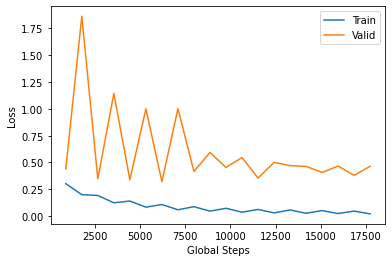

In [9]:
destination_folder = 'bert_gpt_lm_new'
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [10]:

def evaluate(model, test_loader):
    y_pred = []
    y_true = []
    x_text = []

    model.eval()
    with torch.no_grad():
        for (text, labels), _ in tqdm(test_loader, desc='Testing examples'):
                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, labels)

                _, output = output
                x_text.extend(text.tolist())
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['1', '0'])
    ax.yaxis.set_ticklabels(['1', '0'])
    plt.show()
    return x_text, y_pred, y_true


Classification Report:
              precision    recall  f1-score   support

           1     0.8452    0.9750    0.9055      7372
           0     0.9705    0.8215    0.8898      7372

    accuracy                         0.8983     14744
   macro avg     0.9079    0.8983    0.8977     14744
weighted avg     0.9079    0.8983    0.8977     14744



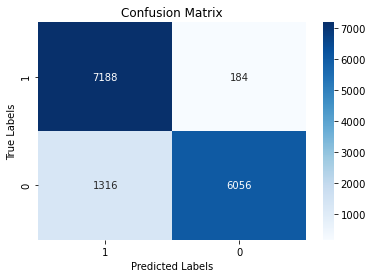

In [11]:
destination_folder = 'bert_gpt_lm_new'
#model = BERT().to(device)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load_checkpoint(destination_folder + '/model.pt', model)
x_text, y_pred, y_true = evaluate(model, test_iter)